In [24]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline

In [25]:
np.set_printoptions(precision=2)
import tensorflow as tf
tf.__version__

'2.15.0'

In [26]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

In [27]:
# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T

In [28]:
# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

In [29]:
print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


In [30]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    def forward(self, input):
        pass
    def backward(self, output_gradient, learning_rate):
        pass

In [31]:
## Define the loss function and its gradient
def cce(Y, Yhat):
    return(-np.mean(np.sum(Y*np.log(Yhat), axis = 0)))
def cce_gradient(Y, Yhat):
    return(Y/Yhat)
# TensorFlow in-built function for categorical crossentropy loss
#cce = tf.keras.losses.CategoricalCrossentropy()

In [32]:
## Softmax activation layer class
class Softmax(Layer):
    def forward(self, input):
        self.output = tf.nn.softmax(input, axis = 0).numpy()
    def backward(self, output_gradient, learning_rate = None):
## Following is the inefficient way of calculating the backward gradient
        softmax_gradient = np.empty((self.input.shape[0], output_gradient.shape[1]), dtype = np.float64)
        for b in range(softmax_gradient.shape[1]):
            softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-self.output[:, b].T) * self.output[:, b], output_gradient[:, b])
        return(softmax_gradient)
## Following is the efficient of calculating the backward gradient
#T = (np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (1, 2, 0)) * np.atleast_2d(se
#return(np.einsum('ijk, ik -> jk', T, output_gradient))

In [33]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
    def backward(self, output_gradient, learning_rate):
## Following is the inefficient way of calculating the backward gradient
        dense_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        for b in range(output_gradient.shape[1]):
            dense_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:,b].reshape(-1, 1).T)
        dense_gradient = (1/output_gradient.shape[1])*dense_gradient
        ## Following is the efficient way of calculating the backward gradient
        #dense_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        self.weights = self.weights + learning_rate * (-dense_gradient)

In [34]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
# Reorder sample indices
    reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
    # Generate batch indices for batch processing
    batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
    return(batch_indices)

In [35]:
## Example generation of batch indices
batch_size = 100
batch_indices = generate_batch_indices(num_samples, batch_size)
print(batch_indices)

[array([46612, 48125, 15305, 45003, 32845, 15291, 44726, 44129, 29919,
       41550, 13671, 21881, 12918, 27719, 42048, 55454, 37470,  9086,
       56152, 18192, 17297, 24562, 31542, 48694,  3512, 14180, 33358,
       33104, 23481, 47970, 32080,    63, 38480, 56793, 37204,  2294,
       54382,  7361, 54125,  7322, 15562, 49684, 22439, 32445,  1741,
       57115, 41594, 21529, 13805, 21915, 41860, 41506, 58710, 31652,
        5010, 36547, 47964, 41627, 47255,  8070, 29239, 23185, 35696,
       51722,  1593, 35786, 26108,  5882, 34272, 13761, 16061, 10544,
       35734, 32771, 27316, 23516,   399, 46240, 33915, 46397, 40714,
        7412, 46937, 46623,  7336, 15955, 57535, 20725,  2313,  6517,
       40476, 23914, 41203,  9472, 15666, 20162, 34935, 41001, 27276,
       55992]), array([22087, 12473, 43891, 49834, 35414, 43496,   739, 37749, 25529,
       36542, 28507, 37745, 47887, 28550, 15426, 36722, 12828,  5043,
       38143, 18184, 35324,  2063, 39874,   430, 18311, 38819, 38676,
   

In [37]:
## Train the 0-layer neural network using batch training with batch size = 16
learning_rate = 0.01 # learning rate
batch_size = 16 # batch size
nepochs = 100 # number of epochs
loss_epoch = np.empty(nepochs, dtype = np.float32) # create empty array to store losses over each epoch

In [14]:
# Neural network architecture
dlayer = Dense(num_features, num_labels) # define dense layer
softmax = Softmax() # define softmax activation layer

In [38]:
# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.
epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    dlayer.forward(X_train[:, batch_indices[b]]) # forward prop
    softmax.forward(dlayer.output) # Softmax activate
    loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss
    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer.backward(grad, learning_rate)
  loss_epoch[epoch] = loss/len(batch_indices)
  print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
  epoch = epoch + 1


AttributeError: 'NoneType' object has no attribute 'shape'

In [22]:
# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.
epoch = 0
while epoch < nepochs:
    batch_indices = generate_batch_indices(num_samples, batch_size)
    loss = 0
    for b in range(len(batch_indices)):
        dlayer.forward(X_train[:, batch_indices[b]]) # forward prop
        softmax.forward(dlayer.output) # Softmax activate
        loss += cce(y_train[:, batch_indices[b]], softmax.output) # calculate loss
        # Backward prop starts here
        grad = cce_gradient(y_train[:, batch_indices[b]], softmax.output)
        grad = softmax.backward(grad)
        grad = dlayer.backward(grad)
    loss_epoch[epoch] = loss/len(batch_indices)
    print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
    epoch = epoch + 1
    

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
## Accuracy on test set
dlayer.forward(X_test)
softmax.forward(dlayer.output)
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)

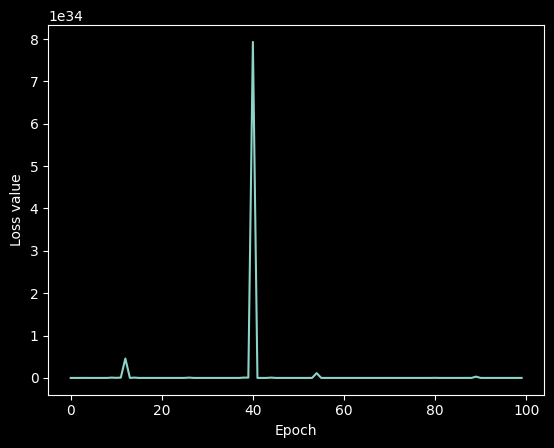

In [21]:
## Plot training loss as a function of epoch:
plt.plot(loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()